# **Modelos de Classificação**


**O objetivo deste notebook é treinar modelos de aprendizado profundo para prever o rótulo/nome de uma determinada fruta tendo apenas uma imagem de entrada.**

## **Bibliotecas utilizadas**

In [ ]:
%%capture
!pip install opendatasets

In [ ]:
import os
import time
import copy
import tarfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import *
from torch import nn,optim
from PIL import Image

## **Baixando dataset do Kaggle com OPENDATASETS**

In [ ]:
od.download('https://www.kaggle.com/moltean/fruits')
#marcosvmedeiros
#d356a300e335f97bbf3559a47bb0d29f

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marcosvmedeiros
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:13<00:00, 102MB/s]


In [ ]:
data_dir = '/content/fruits/fruits-360_dataset/fruits-360'
print(os.listdir(data_dir))

['papers', 'Training', 'LICENSE', 'test-multiple_fruits', 'readme.md', 'Test']


In [ ]:
len(os.listdir(data_dir + '/Training'))

131

## **Pré-processamento dos dados**

In [ ]:
train_dir = data_dir + '/Training'
test_dir = data_dir + '/Test'
batch_size = 32

# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])
# split dos dados
valid_size  = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

In [ ]:
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
test_dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])

# carregando datasets no dataloader
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False),
              'test': DataLoader(test_dataset, batch_size = batch_size, shuffle = False)}

In [ ]:
print("Número total de amostras no dataset: ",len(dataset))
print("Número de amostras de Train: ",len(train_dataset))
print("Número de amostras de Valid: ",len(valid_dataset))
print("Número de amostras de Test: ",len(test_dataset))
print("Número de classes: ",len(dataset.classes))

In [ ]:
dataset.classes[:10]

Inicialmente, temos imagens de 100 x 100 pixel com 3 canais de cores (rgb), mas aplicando as transformações o tamanho da imagem aumenta.


In [ ]:
train_dataset[10][0].shape

torch.Size([3, 299, 299])

Visualizando imagens

In [ ]:
def show_example(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


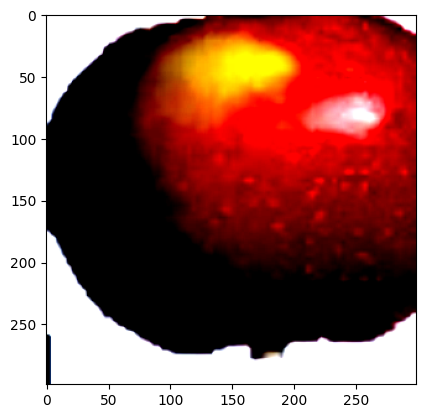

In [ ]:
show_example(*dataset[100])

Visualizando batch de imagens

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 4).permute(1, 2, 0))
    break

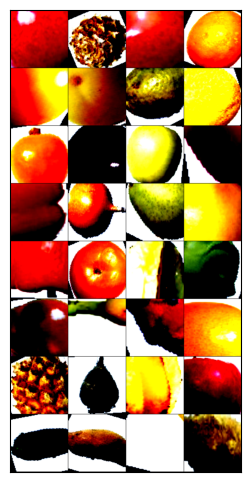

In [ ]:
show_batch(dataloaders['train'])

## **Arquitetura do modelo**

Setando device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

### Carregando modelo pré-treinados para Transfer Learning

In [ ]:
model_name = 'vgg'
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
elif model_name == 'resnet':
    model = models.resnet34(pretrained=True)
    num_in_features = 512
    print(model.fc)
elif model_name == 'inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits=False
    num_in_features = 2048
    print(model.fc)
else:
    print("Unknown model")

### Congelando parâmetros da rede para construir classificador

In [ ]:
for param in model.parameters():
    param.require_grad = False

# Criando classificador
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))

    return classifier

In [ ]:
hidden_layers = None
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)

 # Definindo hiperparametros do modelo
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001,weight_decay=0.001, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=25088, out_features=196, bias=True)
)


## **Treinamento do modelo**

In [ ]:
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Cada época tem uma fase de treinamento e validação
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Definindo modelo para modo de treinamento
            else:
                model.eval()   # Definindo modelo para modo de avaliação
            running_loss = 0.0
            running_corrects = 0
            # Iterarando sobre os dados.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zerar os gradientes dos parâmetros
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        optimizer.step()
                # estatisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              valid_results.append([epoch_loss,epoch_acc])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_name = "FruitVGG.pt"
                path = F"/content/{model_save_name}"
                torch.save(model.state_dict(), path)
        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #carregando best model weights
    model.load_state_dict(best_model_wts)

    return model,train_results,valid_results

In [ ]:
epochs = 3
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

## **Métricas do modelo**

In [ ]:
# Converter tensores para valores na CPU
train_results_np = [[item[0], item[1].cpu().item()] for item in train_results]
valid_results_np = [[item[0], item[1].cpu().item()] for item in valid_results]

# Converter para NumPy para plotagem
train_results_np = np.array(train_results_np)
valid_results_np = np.array(valid_results_np)

# Plot dos Losses
plt.plot(train_results_np[:, 0], '-o', label='Train Loss')
plt.plot(valid_results_np[:, 0], '-o', label='Valid Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 2)  # Ajuste o limite conforme necessário

# Adicionar os valores no gráfico
for i, txt in enumerate(train_results_np[:, 0]):
    plt.annotate(f'{txt:.4f}', (i, txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(valid_results_np[:, 0]):
    plt.annotate(f'{txt:.4f}', (i, txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.show()

In [ ]:
# Plot das Accuracies
plt.plot(train_results_np[:, 1], '-o', label='Train Accuracy')
plt.plot(valid_results_np[:, 1], '-o', label='Valid Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Ajuste o limite conforme necessário

# Adicionar os valores no gráfico
for i, txt in enumerate(train_results_np[:, 1]):
    plt.annotate(f'{txt:.4f}', (i, txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(valid_results_np[:, 1]):
    plt.annotate(f'{txt:.4f}', (i, txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.show()

## **Inferência**

### Carregando modelo gerado

In [ ]:
model.load_state_dict(torch.load('/content/FruitVGG.pt'))
model.to(device)

### Avaliação do modelo

#### Teste por classe

In [ ]:
def class_test(model, test_loader, criterion, classes):
    total_class = len(classes)
    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))
    model.eval()
    for data, target in test_loader:
        data,target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(len(target) - 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    test_loss = test_loss / len(test_loader.dataset)
    print('Loss de teste: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Acuracia de teste %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Acuracia de teste %5s: N/A (no training examples)' % (classes[i]))

    print('\nAcuracia de teste (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
class_test(model, dataloaders['test'], criterion, dataset.classes)

### Inferência com image do conjunto de teste

In [ ]:
def inf_test(model, file, transform, classes):
    file = Image.open(file).convert('RGB')
    img = transform(file).unsqueeze(0)
    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [ ]:
inf_test(model, '/content/fruits/fruits-360_dataset/fruits-360/Test/Cocos/0_100.jpg', data_transforms['test'], dataset.classes)

In [ ]:
inf_test(model, '/content/fruits/fruits-360_dataset/fruits-360/Test/Mango/0_100.jpg', data_transforms['test'], dataset.classes)

In [ ]:
inf_test(model, '/content/fruits/fruits-360_dataset/fruits-360/Test/Tomato 4/10_100.jpg', data_transforms['test'], dataset.classes)

### Inferência com imagens reais

In [ ]:
!wget https://img.freepik.com/fotos-premium/vegetais-de-tomate-isolados-no-branco-trajeto-de-grampeamento-da-fruta-do-tomate-fresco-foto-macro-de-tomate_299651-601.jpg?w=826
!mv /content/vegetais-de-tomate-isolados-no-branco-trajeto-de-grampeamento-da-fruta-do-tomate-fresco-foto-macro-de-tomate_299651-601.jpg?w=826 tomate.jpg

In [ ]:
inf_test(model, '/content/tomate.jpg', data_transforms['test'], dataset.classes)